# Lanes Detection 

In this notebook, I am detecting white road lanes by applying color thresholding to the image, isolating the pixels that correspond to the white color.

In [1]:
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
plt.rcParams['figure.dpi'] = 200
%matplotlib inline

In [2]:
def combine_images(image1, image2, separator_width=5):
    # Get dimensions
    height, width = image1.shape[:2]
    
    # Create a blank image for titles and the separator
    combined_width = width * 2 + separator_width
    combined_image = np.zeros((height, combined_width, 3), dtype=np.uint8)
    
    # Place images with a separator
    combined_image[:, :width] = image1
    combined_image[:, width + separator_width:] = image2
    
    # Draw the separator
    combined_image[:, width:width + separator_width] = [255, 255, 255]  # White separator
    
    return combined_image

In [3]:
def rgb_threshold_mask(image: np.ndarray, thresholds: np.ndarray = np.array([200, 200, 200])):
    # Mask pixels below the threshold
    color_thresholds = (image < thresholds).any(axis=-1)
    return color_thresholds

In [4]:
def triangular_region_flag(image: np.ndarray, rio: dict[str, list]) -> np.ndarray:
    """
    Creates a binary mask that flags the pixels inside a triangular region 
    defined by three points: 'left_bottom', 'right_bottom', and 'top' from the 'rio' dictionary.

    The function calculates the boundaries of the triangle by performing a 
    linear fit for each side, then iterates over all pixels to check whether 
    they are within the triangular region.

    Args:
        image (np.ndarray): Input image to create the mask for.
        rio (dict[str, list]): A dictionary containing the coordinates of 
                               the three vertices of the triangle as lists.

    Returns:
        np.ndarray: A boolean array where True indicates that the pixel is 
                    inside the triangular region.
    """
    ysize, xsize, _ = image.shape

    # (x=0, y=0) is in the upper left
    left_bottom, right_bottom, top = rio['left_bottom'], rio['right_bottom'], rio['top']

    # Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
    # np.polyfit returns the coefficients [A, B] of the fit
    left_vector = np.polyfit((left_bottom[0], top[0]), (left_bottom[1], top[1]), 1)
    right_vector = np.polyfit((right_bottom[0], top[0]), (right_bottom[1], top[1]), 1)
    bottom_vector = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Create x-coordinates
    x_coords = np.arange(0, xsize)

    # Calculate the corresponding y-coordinates for each line
    y_left = left_vector[0] * x_coords + left_vector[1]
    y_right = right_vector[0] * x_coords + right_vector[1]
    y_bottom = bottom_vector[0] * x_coords + bottom_vector[1]

    # create flag for each point
    region_flag = np.zeros((ysize, xsize), dtype=bool)
    # Create a mask for the region inside the lines
    for x in range(xsize):
        for y in range(ysize):
            region_flag[y, x] = (y > y_left[x]) and (y > y_right[x]) and (y < y_bottom[x])

    return region_flag

#  Regular Color Selection

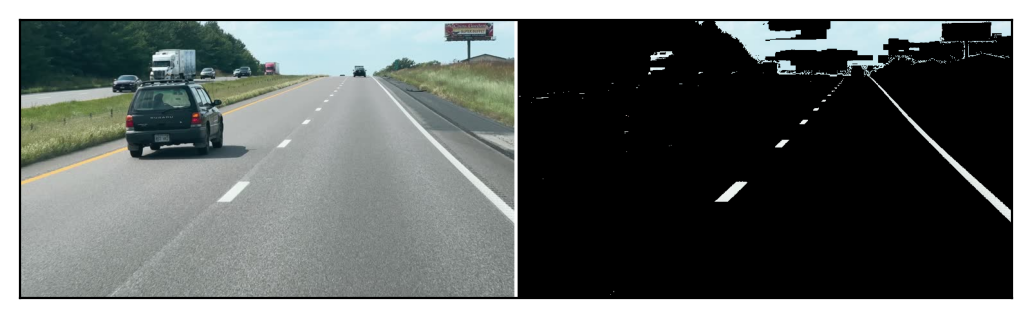

In [5]:
# Read in the image
image = mpimg.imread('img/lanes/lane.jpg')

ysize, xsize, _ = image.shape
color_select = image.copy()

color_thresholds = rgb_threshold_mask(image)

color_select[color_thresholds] = [0, 0, 0]

combined_image = combine_images(image, color_select)

plt.imshow(combined_image)
plt.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)
plt.show()



#  Region Masking  

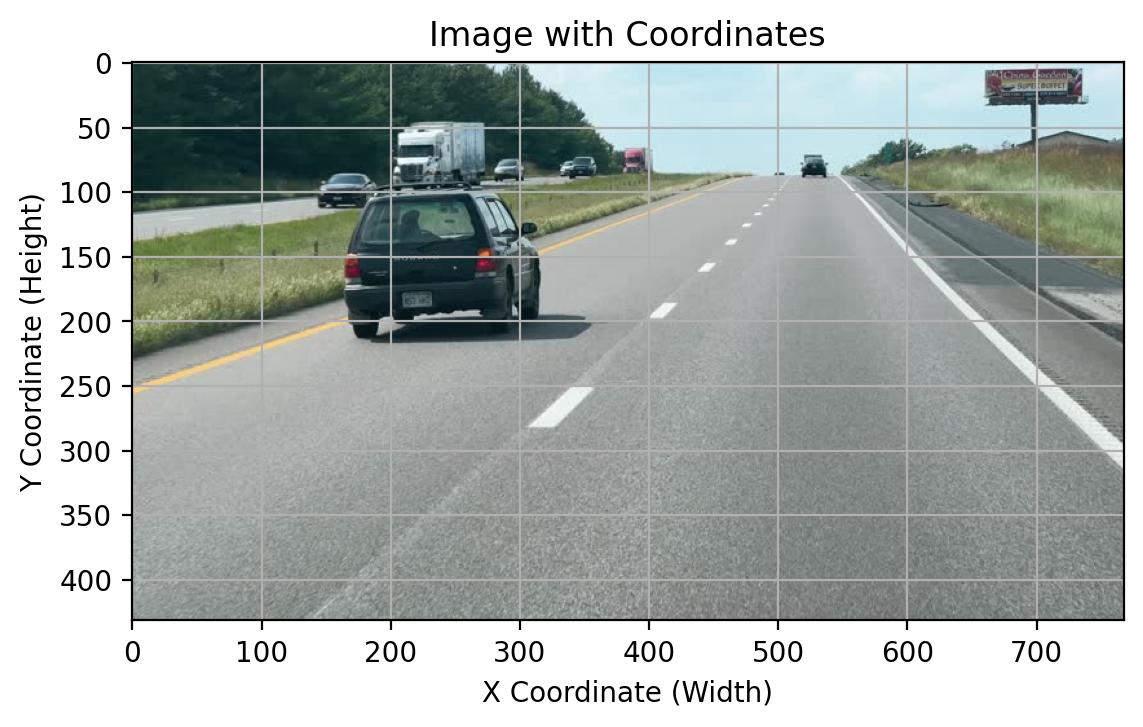

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('img/lanes/lane.jpg')

# Display the image with coordinate axes
plt.imshow(image)
plt.title("Image with Coordinates")

# Add grid lines to help with coordinate selection
plt.grid(True)

# Display the x and y axis for reference
plt.xlabel('X Coordinate (Width)')
plt.ylabel('Y Coordinate (Height)')

# Show the image with the grid and coordinate system
plt.show()

In [7]:
roi_triangel = {
    'left_bottom': [100, 400],
    'right_bottom': [750, 400],
    'top': [500, 50]
}

In [8]:
print(image.shape)

(432, 768, 3)


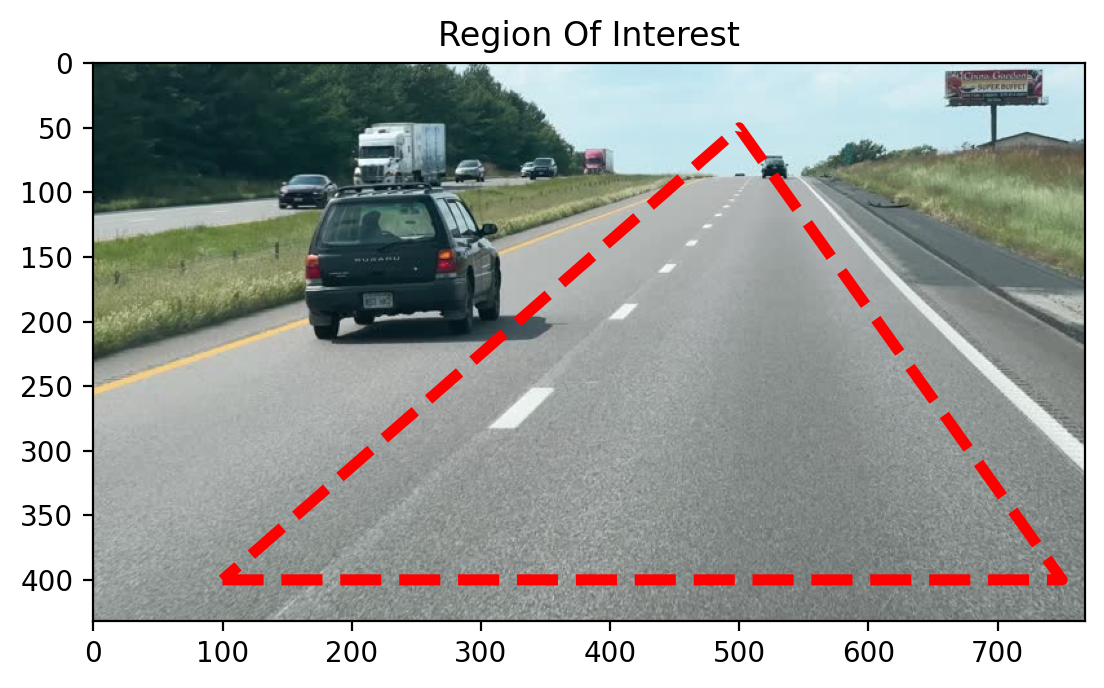

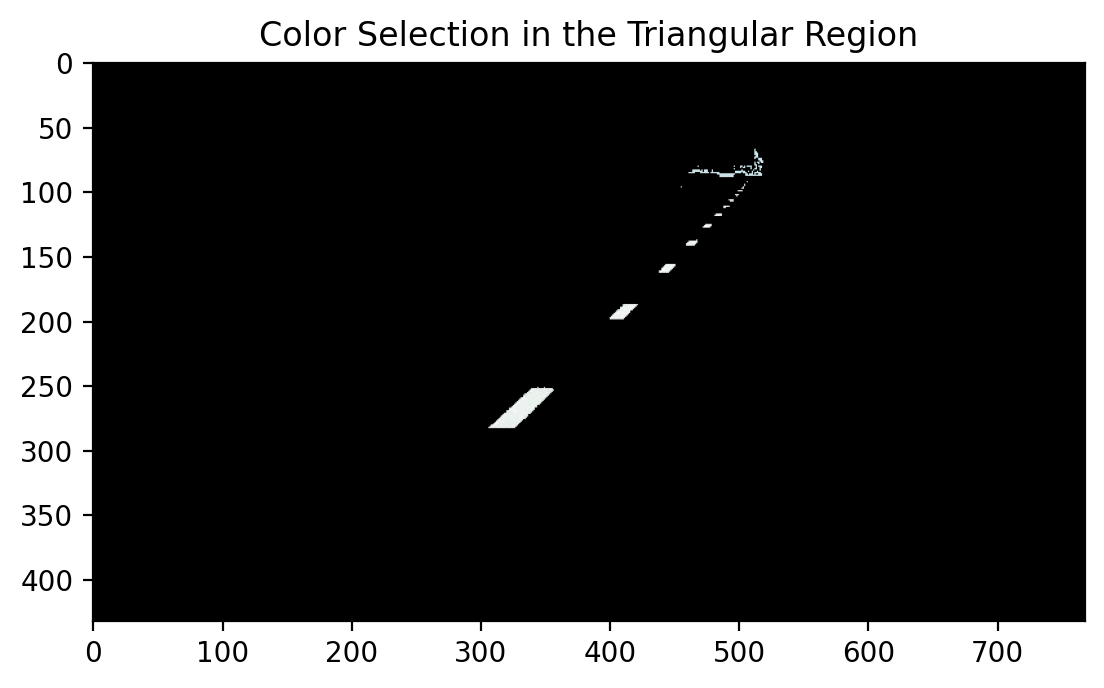

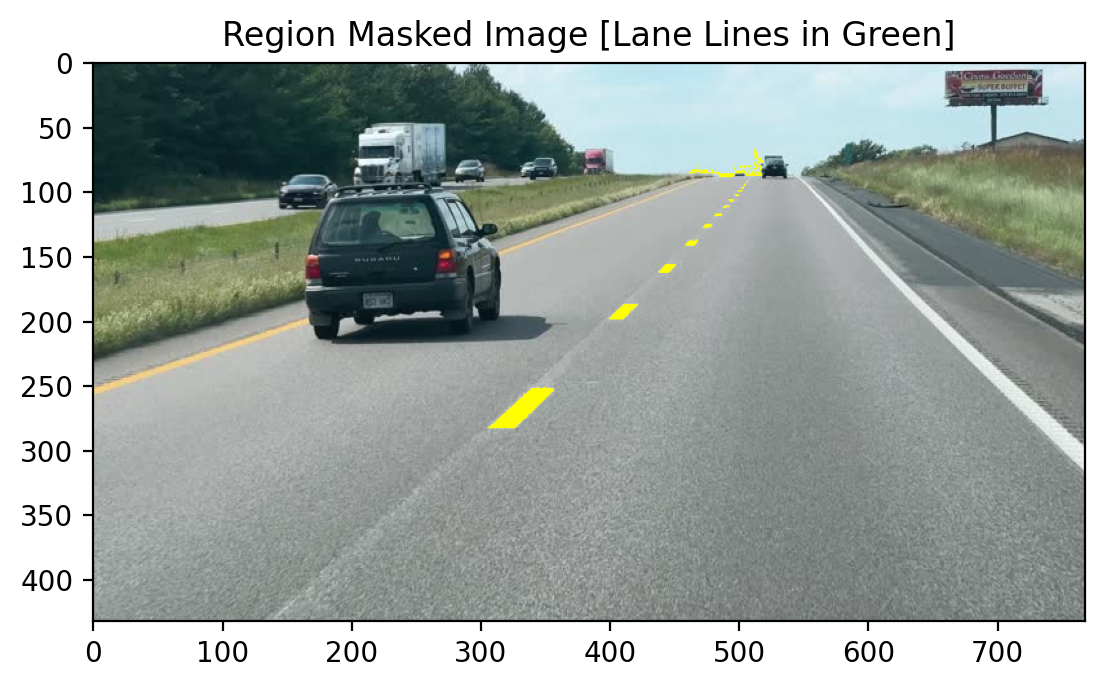

In [9]:
image = mpimg.imread('img/lanes/lane.jpg')
color_select, line_image = image.copy(), image.copy()

color_thresholds = rgb_threshold_mask(image)
region_thresholds = triangular_region_flag(image, roi_triangel)

ysize, xsize, _ = image.shape

left_bottom, right_bottom, top = roi_triangel['left_bottom'], roi_triangel['right_bottom'], roi_triangel['top']

# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]

# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [255, 255, 0]

# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], top[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], top[1], left_bottom[1]]
plt.plot(x, y, 'r--', lw=4)
plt.title("Region Of Interest")
plt.show()
plt.imshow(color_select)
plt.title("Color Selection in the Triangular Region")
plt.show()
plt.imshow(line_image)
plt.title("Region Masked Image [Lane Lines in Green]")
plt.show()
